In [296]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
from pyspark import SparkContext

SparkContext.setSystemProperty('spark.executor.memory', '5g')

In [297]:
# inputFile = "sample-data.txt"
inputFile = "publications.txt"

titlesRDD = sc.textFile(inputFile)\
          .filter(lambda line : line.startswith("#*"))\
          .map(lambda line : line[2:].strip())\
          .cache()

# convert RDD to DF
titlesDF = titlesRDD.map(lambda title : Row(title)).toDF(['titles'])

In [298]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql import Row

# perform tokenization

def tokenize(titlesDF, inputCol, outputCol):
    regexTokenizer = RegexTokenizer(inputCol=inputCol, outputCol=outputCol, pattern="\\W")    
    tokenizedTitles = regexTokenizer.transform(titlesDF)
    return tokenizedTitles

In [299]:
from pyspark.ml.feature import CountVectorizer

# Truncates given (sparse) vectors to the N most frequent words
# fit a CountVectorizerModel from the corpus.

def countVectorize(tokenizedTitles, N):
    countVectorizer = CountVectorizer(inputCol="tokens", outputCol="countVector", vocabSize=N, minDF=1.0)
    cvModel = countVectorizer.fit(tokenizedTitles)
    cvResult = cvModel.transform(tokenizedTitles)
    return cvModel, cvResult

In [300]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

# perform PCA with k components on the counts.

def performPCA(cvResult, k, iCol):
    pca = PCA(k=k, inputCol=iCol, outputCol="principalComponents")
    pcaModel = pca.fit(cvResult)
    pcaResult = pcaModel.transform(cvResult).select("principalComponents")
    return pcaModel, pcaResult

In [301]:
import matplotlib.pyplot as plt

# Plot the eigenvalues of the principal components.

def plotEigenValues(pcaModel):
    plt.plot(pcaModel.explainedVariance)
    plt.ylabel('Eigenvalues of PCs')
    plt.xlabel('Principal Components')
    plt.show()

In [302]:
# Calculate how many components are needed to explain N% of the total variance

def getComponentCount(pcaModel, N):
    for i in range(1, len(pcaModel.explainedVariance)):
        if sum(pcaModel.explainedVariance[0:i])/sum(pcaModel.explainedVariance)*100 >= N:
            return i

In [303]:
import numpy as np

# returns a set of most important features in given principal components

def getImportantFeatures(PCs, features, threshold):
    principalComponents = PCs.toArray().transpose()
    print("PC id -> Important Feature")
    for i in range(0, len(principalComponents)):
        for index,feature in enumerate(principalComponents[i]):
                if(np.abs(feature) > threshold):
                    print(i," ->" ,features[index])

In [304]:
def scatterPlot(PCs):
    samplePC = PCs.take(1000)
    PCMat = []
    for pc in samplePC:
        PCMat.append(pc[0])
    scatterX = np.array(PCMat).transpose()[0]
    scatterY = np.array(PCMat).transpose()[1]    
    plt.scatter(scatterX, scatterY)    
    plt.show()

In [305]:
from pyspark.ml.feature import StopWordsRemover

# remove stop words from given tokens

def removeStopWords(tokenizedTitles, stopWords):
    remover = StopWordsRemover(inputCol="oldTokens", outputCol="tokens", stopWords=stopWords)
    filteredTokenizedTitles = remover.transform(tokenizedTitles)
    return filteredTokenizedTitles

In [306]:
# Calculates TF-IDF features

def getTFIDF(tf):
    idf = IDF(inputCol="countVector", outputCol="tfidf")
    idfModel = idf.fit(tf)
    TFIDF = idfModel.transform(tf)
    return TFIDF

<h1>FIRST PART</h1>

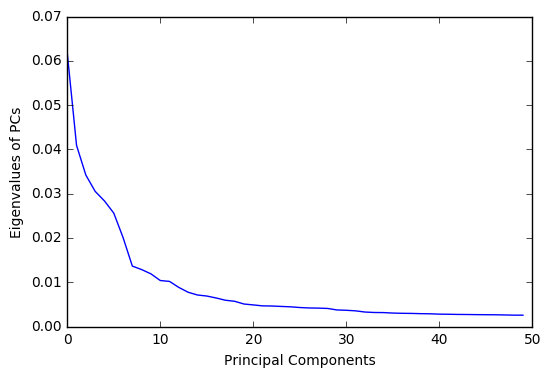

Components needed to explain 50% of total variance:  7


In [307]:
# a. Transform titles to word count vectors. Truncate your (sparse) vectors to the 1000 most frequent words 
# and perform PCA with 50 components on the counts.

tokenizedTitles = tokenize(titlesDF, "titles", "tokens")
cvModel, cvResult = countVectorize(tokenizedTitles, 1000)
pcaModel, pcaResult = performPCA(cvResult, 50, "countVector")

# b. Plot the eigenvalues of the principal components. Calculate how many components are needed 
# to explain 50% of the total variance?

plotEigenValues(pcaModel)
print("Components needed to explain 50% of total variance: ", getComponentCount(pcaModel, 50))

In [308]:
# c. Identify which words are important in each of the principal components.
# Print out the words for which the absolute value of the component is larger than 0.20 of the norm.

getImportantFeatures(pcaModel.pc, cvModel.vocabulary, 0.2)

PC id -> Important Feature
0  -> of
0  -> the
1  -> for
1  -> a
2  -> and
3  -> for
3  -> a
3  -> the
3  -> in
4  -> of
4  -> the
4  -> in
5  -> of
5  -> for
5  -> a
5  -> the
5  -> in
5  -> on
6  -> in
6  -> on
6  -> based
7  -> on
7  -> based
7  -> with
7  -> to
7  -> an
8  -> with
8  -> to
8  -> using
9  -> on
9  -> based
9  -> to
9  -> using
10  -> on
10  -> based
10  -> using
10  -> an
11  -> to
11  -> using
11  -> an
12  -> systems
12  -> networks
13  -> systems
13  -> networks
13  -> wireless
14  -> system
15  -> analysis
15  -> data
16  -> analysis
16  -> data
17  -> model
18  -> time
18  -> real
19  -> design
19  -> information
20  -> approach
20  -> time
20  -> algorithm
20  -> information
21  -> approach
21  -> algorithm
21  -> by
21  -> network
21  -> control
21  -> learning
21  -> neural
22  -> design
22  -> approach
22  -> algorithm
22  -> by
22  -> information
22  -> from
22  -> network
22  -> learning
23  -> by
23  -> information
23  -> network
23  -> learning
24  -> ap

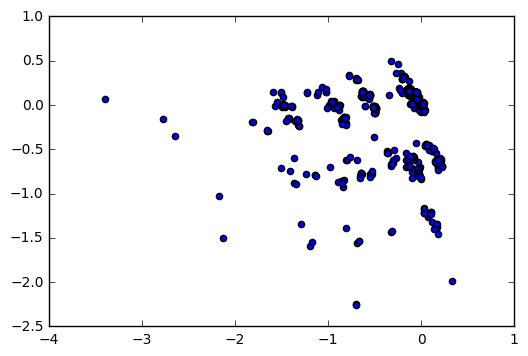

In [309]:
# d. Make a scatter plot of some reasonably sized sample (1k-10k titles). Explain the structure 
# (or lack thereof) you see based on your results from item b-c.
scatterPlot(pcaResult)

<h3>Stop words are words the occur most frequent in any language and are present in all most all documents. Since, in this case stop words are not removed, 30-40% of the 1000 most frequent words considered for computing PCA in 1.a. would be stop words. As a result, the most important words (features) for most of the principal component are stop words. And, only 7 principal components (having max aigenvalues and orthogonal to each other) are required to represent 50% of total variace. This is very much evident from the line graph of eigenvalues of PCs.
<br><br>
From the scatter plot, we can see that there are clusters of PCs and since these PCs represent publication titles, we can infer that these PCs(and titles) belong to some academic community like NIPS, VLDB etc.<h3>

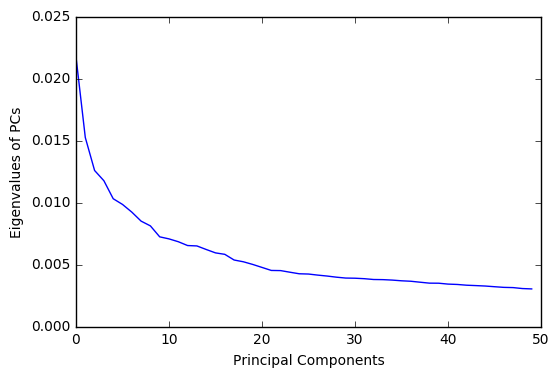

Components needed to explain 50% of total variance:  15
PC id -> Important Feature
0  -> based
1  -> using
2  -> systems
2  -> networks
3  -> systems
3  -> networks
3  -> wireless
4  -> system
5  -> analysis
5  -> data
6  -> analysis
6  -> data
7  -> model
8  -> time
8  -> information
8  -> real
9  -> design
9  -> approach
9  -> information
10  -> approach
10  -> time
10  -> algorithm
10  -> information
11  -> design
11  -> approach
11  -> network
12  -> approach
12  -> algorithm
12  -> information
12  -> network
12  -> control
13  -> information
13  -> network
13  -> neural
14  -> learning
15  -> information
15  -> control
15  -> multi
16  -> control
16  -> multi
17  -> performance
17  -> method
17  -> web
17  -> software
18  -> performance
18  -> web
18  -> software
18  -> high
19  -> web
19  -> software
20  -> method
20  -> web
20  -> software
20  -> new
21  -> distributed
21  -> image
21  -> efficient
21  -> study
21  -> case
22  -> method
22  -> web
22  -> software
22  -> distribu

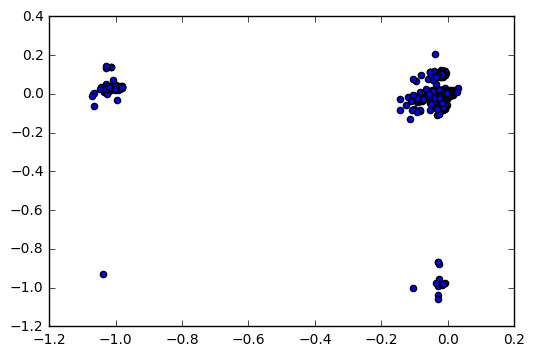

In [310]:
# e. Run a preprocessing step to remove stop words (a list of stop words is provided which is identical 
# to the list used in Spark). Rerun steps b-d and evaluate whether this has improved your representation.

stopWords = sc.textFile("stopwords_english.txt").collect()
tokenizedTitles = tokenize(titlesDF, "titles", "oldTokens")
filteredTokenizedTitles = removeStopWords(tokenizedTitles, stopWords)
cvModel, cvResult = countVectorize(filteredTokenizedTitles, 1000)
pcaModel, pcaResult = performPCA(cvResult, 50, "countVector")
plotEigenValues(pcaModel)
print("Components needed to explain 50% of total variance: ", getComponentCount(pcaModel, 50))
getImportantFeatures(pcaModel.pc, cvModel.vocabulary, 0.2)
scatterPlot(pcaResult)

<h3>After removing the stop words, the 1000 most frequent words considered for computing PCA would be the words that carry valuable information. As a result, features extracted from each title would carry more valuable information about communities. 
<br><br>
TThe line graph of eigenvalues of PCs is not as skewed(on right) as in 1.d. So we can say that more PCs would be required to explain total variance. After removing stop words, 15 principal components (having max aigenvalues and orthogonal to each other) are required to represent 50% of total variace.
<br><br>
From the scatter plot, we can see that there are clusters(representing academic communities) are very well seperated. As a result, this PCA model gives more information than PCA with stop words.<h3>

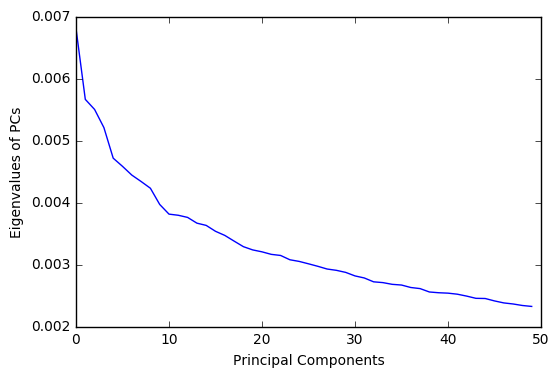

Components needed to explain 50% of total variance:  20
PC id -> Important Feature
0  -> of
0  -> the
0  -> on
1  -> a
1  -> on
1  -> based
1  -> to
1  -> an
1  -> system
1  -> approach
2  -> in
2  -> to
2  -> networks
2  -> wireless
2  -> sensor
3  -> in
3  -> on
3  -> based
3  -> to
4  -> of
4  -> a
4  -> with
4  -> to
4  -> systems
4  -> time
5  -> and
5  -> the
5  -> systems
5  -> information
6  -> and
6  -> a
6  -> with
6  -> to
6  -> using
6  -> system
6  -> time
7  -> and
7  -> on
7  -> with
7  -> to
7  -> using
7  -> analysis
7  -> data
8  -> a
8  -> an
9  -> and
9  -> in
9  -> with
9  -> using
9  -> systems
9  -> time
9  -> real
10  -> with
10  -> using
10  -> data
10  -> de
11  -> with
11  -> data
11  -> algorithm
12  -> using
12  -> analysis
12  -> data
12  -> time
12  -> algorithm
12  -> de
13  -> with
13  -> using
13  -> systems
13  -> system
13  -> analysis
13  -> time
13  -> real
14  -> with
14  -> using
14  -> systems
14  -> data
14  -> time
14  -> information
14  -> de

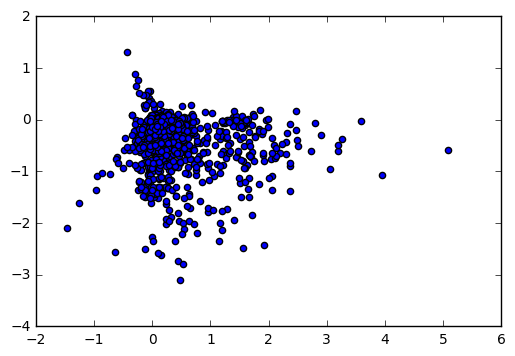

In [311]:
# f. Calculate TF-IDF features for all titles and rerun the operations in parts b-d of this exercise. 
# How have your results changed?

tokenizedTitles = tokenize(titlesDF, "titles", "tokens")
cvModel, cvResult = countVectorize(tokenizedTitles, 1000)
TFIDF = getTFIDF(cvResult)
pcaModel, pcaResult = performPCA(TFIDF, 50, "tfidf")
plotEigenValues(pcaModel)
print("Components needed to explain 50% of total variance: ", getComponentCount(pcaModel, 50))
getImportantFeatures(pcaModel.pc, cvModel.vocabulary, 0.2)
scatterPlot(pcaResult)

<h1>Second Part</h1>

In [312]:
filePath = "publications.txt"
# filePath = "sample-data.txt"
file = open(filePath,'r')

MLPapers=[] # Titles for machine learning papers published at ‘NIPS’
DBPapers=[] # Titles for database papers published at ‘VLDB’

for line in file:      
         
    # get publication title
    if line.startswith("#*"):
        title = line[2:].strip()

    # get publication venue
    if line.startswith("#c"):
        venue = line[2:].strip()
        if venue != "" and title != "":        
            if venue=="NIPS":
                MLPapers.append(title)
            elif venue=="VLDB":
                DBPapers.append(title)

In [313]:
# concatenate both titles
allPapers = MLPapers + DBPapers
# convert python list to DF
titlesDF = sc.parallelize(allPapers).map(lambda title : Row(title)).toDF(['titles'])

In [314]:
def MultivariateScatter(PC1, PC2):
    samplePC = PC1.take(1000)
    PCMat = []
    for pc in samplePC:
        PCMat.append(pc[0])
    scatterX1 = np.array(PCMat).transpose()[0]
    scatterY1 = np.array(PCMat).transpose()[1]         
    
    samplePC = PC2.take(1000)
    PCMat = []
    for pc in samplePC:
        PCMat.append(pc[0])
    scatterX2 = np.array(PCMat).transpose()[0]
    scatterY2 = np.array(PCMat).transpose()[1]    
    
    plt.scatter(scatterX1, scatterY1, color="red")
    plt.scatter(scatterX2, scatterY2, color="green")
    
    plt.show()

In [315]:
spark.conf.set("spark.sql.crossJoin.enabled", True)

def MultivariateAnalysis(pcaModel, MLPapers):
    title_PCs = pcaModel.transform(TFIDF).select("titles","principalComponents")
    title_PCs.createOrReplaceTempView("title_PCs")

    TitlesNIPS = sc.parallelize(MLPapers).map(lambda title : Row(title)).toDF(['TitlesNIPS'])
    TitlesNIPS.createOrReplaceTempView("TitlesNIPS")

    NIPSDF = spark.sql("SELECT principalComponents FROM title_PCs where titles in (select * from TitlesNIPS)")
    VLDBDF = spark.sql("SELECT principalComponents FROM title_PCs where titles not in (select * from TitlesNIPS)")
    
    MultivariateScatter(NIPSDF, VLDBDF)

<h3> Constructing word count vectors from concatenated list(NIPS and VLDB). And, Repeating steps b-d and comparing word count results to TF-IDF results.
<br><br>
Also, plotting a scatter plot of these two principal components, showing the titles of NIPS in red and titles of VLDB in green.</h3>

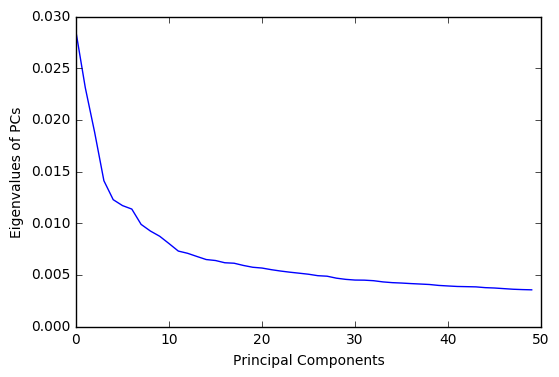

Components needed to explain 50% of total variance:  14
PC id -> Important Feature
0  -> learning
0  -> data
1  -> learning
1  -> data
1  -> neural
2  -> data
2  -> neural
2  -> networks
3  -> using
3  -> networks
3  -> database
3  -> information
3  -> systems
3  -> processing
4  -> using
4  -> database
4  -> systems
5  -> networks
5  -> model
6  -> networks
6  -> model
6  -> database
6  -> models
6  -> information
6  -> processing
7  -> database
7  -> models
7  -> based
8  -> model
8  -> models
8  -> based
8  -> network
9  -> neural
9  -> networks
9  -> based
9  -> information
9  -> network
10  -> models
10  -> databases
10  -> analysis
10  -> query
10  -> relational
10  -> object
11  -> information
11  -> systems
11  -> system
11  -> databases
11  -> large
12  -> information
12  -> databases
12  -> large
12  -> processing
12  -> query
12  -> optimization
13  -> analysis
13  -> query
14  -> system
14  -> databases
14  -> analysis
14  -> large
14  -> multi
14  -> approach
14  -> classi

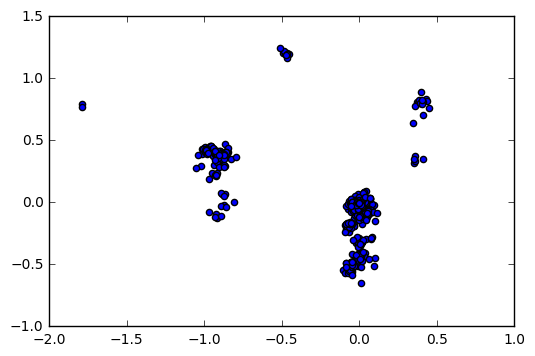

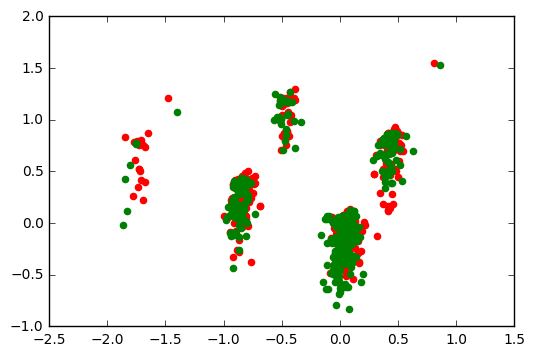

In [316]:
# Analysis using word count vectors
# NOTE: stop words are removed to get better diffrentiation of NIPS and VLDB papers

tokenizedTitles = tokenize(titlesDF, "titles", "oldTokens")
filteredTokenizedTitles = removeStopWords(tokenizedTitles, stopWords)
cvModel, cvResult = countVectorize(filteredTokenizedTitles, 1000)
pcaModel, pcaResult = performPCA(cvResult, 50, "countVector")
plotEigenValues(pcaModel)
print("Components needed to explain 50% of total variance: ", getComponentCount(pcaModel, 50))
getImportantFeatures(pcaModel.pc, cvModel.vocabulary, 0.2)
scatterPlot(pcaResult)
MultivariateAnalysis(pcaModel, MLPapers)

<h3> Constructing TF-IDF features from concatenated list(NIPS and VLDB). And, Repeating steps b-d and comparing word count results to TF-IDF results.
<br><br>
Also, plotting a scatter plot of these two principal components, showing the titles of NIPS in red and titles of VLDB in green.</h3>

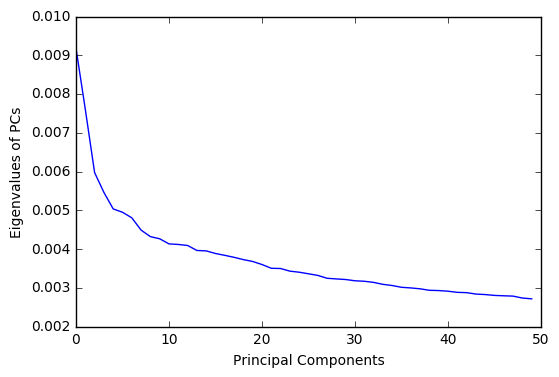

Components needed to explain 50% of total variance:  20
PC id -> Important Feature
0  -> neural
0  -> information
0  -> systems
0  -> processing
0  -> advances
0  -> december
1  -> learning
1  -> data
1  -> neural
1  -> networks
1  -> database
1  -> system
2  -> learning
2  -> neural
2  -> networks
2  -> network
3  -> data
3  -> database
3  -> base
4  -> learning
4  -> database
4  -> systems
4  -> reinforcement
5  -> learning
5  -> database
5  -> models
5  -> based
5  -> gaussian
6  -> networks
6  -> model
6  -> recognition
6  -> object
6  -> visual
7  -> using
7  -> models
7  -> support
7  -> vector
7  -> machines
8  -> using
8  -> model
9  -> using
9  -> databases
9  -> large
9  -> object
9  -> scale
10  -> using
10  -> model
10  -> based
10  -> analysis
10  -> gaussian
10  -> support
10  -> vector
11  -> using
11  -> models
11  -> based
11  -> network
11  -> analysis
12  -> analysis
12  -> multi
12  -> time
12  -> high
12  -> support
12  -> vector
12  -> dimensional
13  -> model
13 

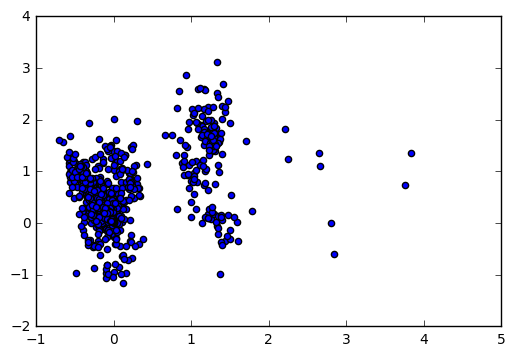

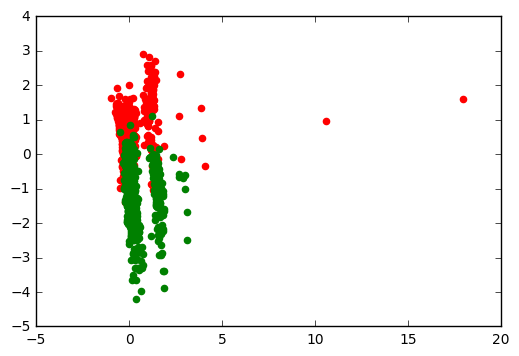

In [317]:
# Analysis using TF-IDF features
# NOTE: stop words are removed to get better diffrentiation of NIPS and VLDB papers

tokenizedTitles = tokenize(titlesDF, "titles", "oldTokens")
filteredTokenizedTitles = removeStopWords(tokenizedTitles, stopWords)
cvModel, cvResult = countVectorize(filteredTokenizedTitles, 1000)
TFIDF = getTFIDF(cvResult)
pcaModel, pcaResult = performPCA(TFIDF, 50, "tfidf")
plotEigenValues(pcaModel)
print("Components needed to explain 50% of total variance: ", getComponentCount(pcaModel, 50))
getImportantFeatures(pcaModel.pc, cvModel.vocabulary, 0.2)
scatterPlot(pcaResult)
MultivariateAnalysis(pcaModel, MLPapers)

<h3>Did PCA succeed in uncovering the differences between the communities?
<br><br>
As we can see from the two multi-colored scatterplots, PCA did not do well in uncovering the differences between the two academic communities viz. NIPS and VLDB. This might be because, the features (words in publication titles) representing NIPS and VLDB titles might the similiar.<h3>